In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *

from hermes3.utils import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    dict(name="base", id="upst1b-2e19_MASTER_RERUN", unnormalise = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst1b-2e19_MASTER_RERUN
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Plot fluctuations

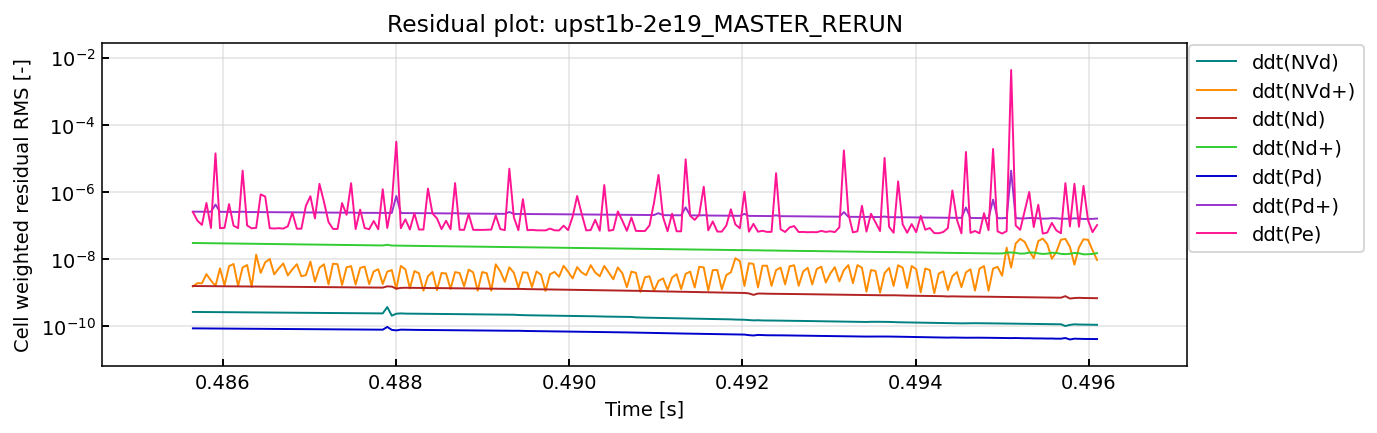

In [4]:
name = "base"

fig, ax = plt.subplots(figsize = (10,3))
plot_ddt(cs[name], ax = ax)

# Find exact fluctuations

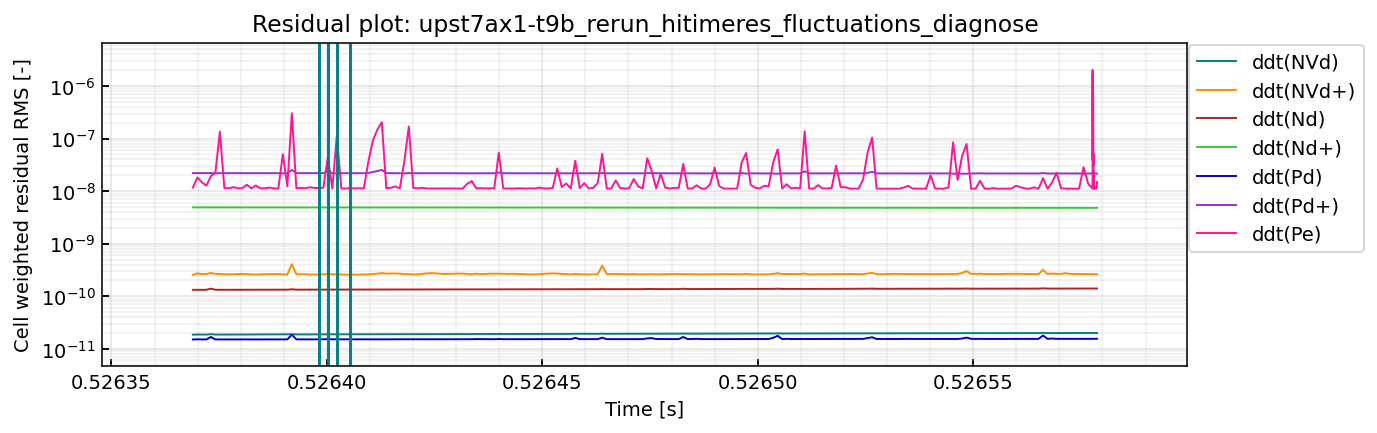

In [ ]:
name = "base"

fig, ax = plt.subplots(figsize = (10,3))
plot_ddt(cs[name], ax = ax)


ds_slices = []
tind_slices = []

time_slices = [0.526398, 0.52640, 0.526402, 0.526405]
# time_slices = [0.526408, 0.52641, 0.526412]

ylim = ax.get_ylim()

for time in time_slices:
    ds_1 = ds.sel(t = time, method = "nearest")
    tind_1 = ds_1["t"].values
    ax.vlines(tind_1, *ylim)
    
    ds_slices.append(ds_1)
    tind_slices.append(tind_1)
    
    
ax.set_ylim(ylim)
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))


In [ ]:
tind_slices

[array(0.69385649), array(0.69448287), array(0.69557904), array(0.69704059)]

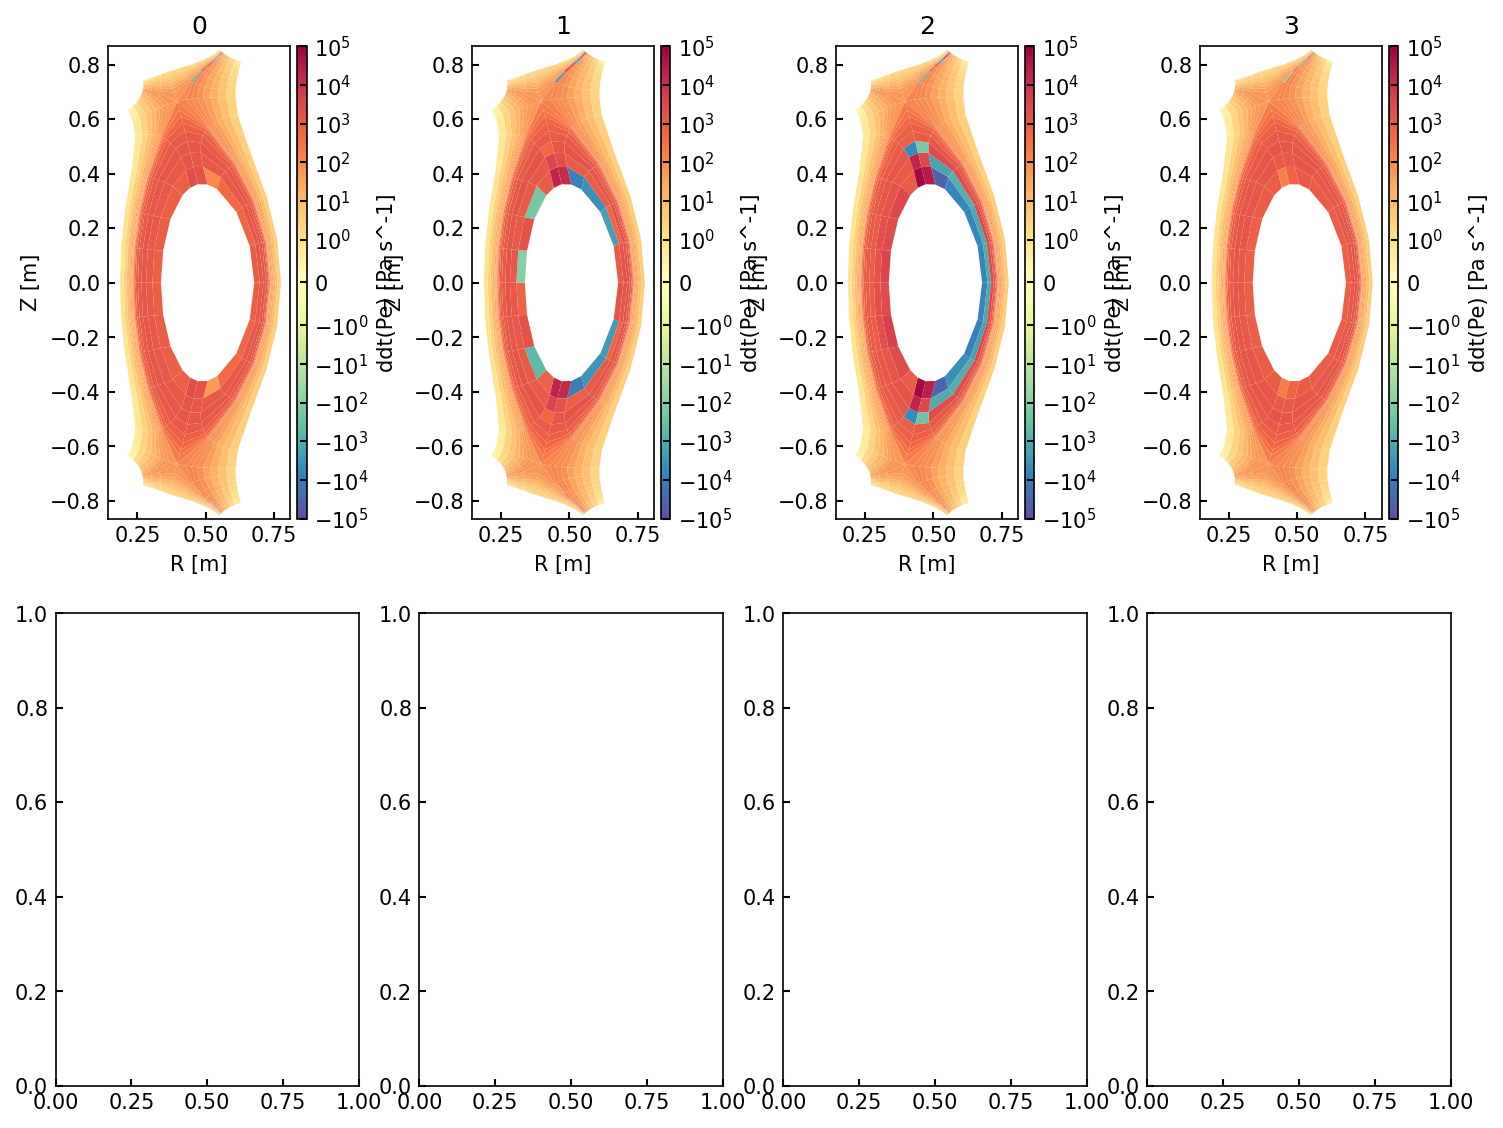

In [ ]:
ds = cs["base"].ds
no_times = len(tind_slices)
fig, axes = plt.subplots(2 ,no_times, figsize = (3.0*no_times,4.5*2), dpi = 150)
style = dict(cmap = "Spectral_r", targets = False, separatrix_kwargs = dict(
    color="white", linestyle = "-", linewidth = 0),antialias = True,
             logscale = True)

for i, time in enumerate(tind_slices):
    
    ax = axes[0,i]
    
    ds["ddt(Pe)"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -1e5, vmax = 1e5, **style)
    ax.set_title(f"{i}")
    

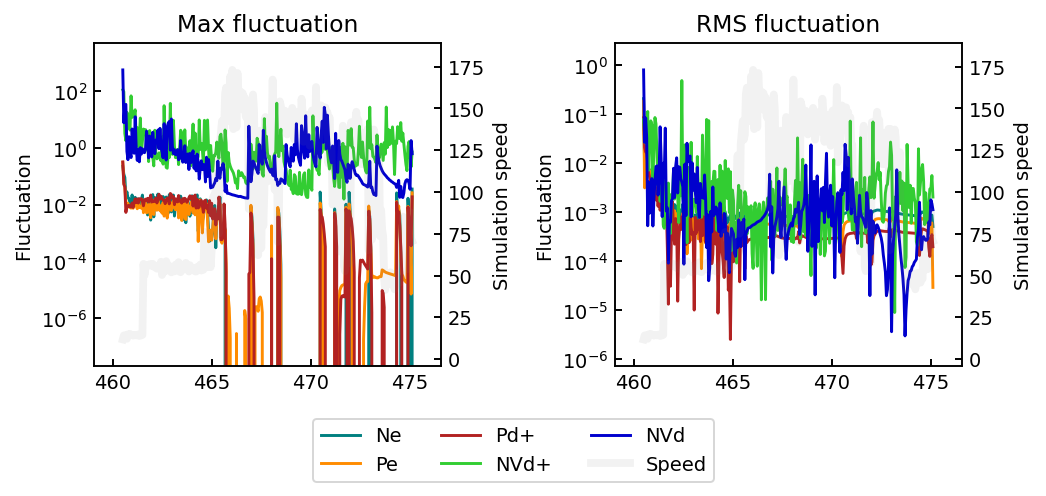

In [35]:
name = "base"
ds = cs[name].ds

t = ds["t"] * 1000
stime = np.diff(t, prepend = t[0]*0.99)
ms_per_24hrs = (stime) / (ds["wtime"]/(60*60*24))  # ms simulated per 24 hours

params = ["Ne", "Pe", "Pd+", "NVd+", "NVd"]
# params = ["Pe", "NVd+"]
# params = ["NVd+"]

fig, axes = plt.subplots(1, 2, figsize = (8, 3))

for i, param in enumerate(params):
    
    data = ds[param].values + 1e-10
    diff = np.diff(data, axis=0, prepend=0) / data

    diff_max = np.max(diff, axis=(1,2))
    diff_rms = np.sqrt(np.mean(diff, axis=(1,2))**2)


    speed_style = dict(c = "grey", alpha = 0.1, lw = 4, label = "speed")

    # t = ds["t"].values
    ax = axes[0]
    ax.set_title("Max fluctuation")
    ax.plot(t[1:], diff_max[1:],  label = param)
    ax.set_yscale("log")

    
    # t = ds["t"].values
    ax = axes[1]
    ax.set_title("RMS fluctuation")
    ax.plot(t[1:], diff_rms[1:])
    ax.set_yscale("log")


speed_style = dict(c = "grey", alpha = 0.1, lw = 4)
    
for i, ax in enumerate(axes):
    ax.set_ylabel("Fluctuation")
    ax2 = ax.twinx()
    if i == 0:
        label = "Speed"
    else:
        label = ""
    ax2.plot(t[1:], ms_per_24hrs[1:], **speed_style, label = label)
    ax2.set_ylabel("Simulation speed")

fig.subplots_adjust(wspace = 0.5)
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.01), ncols = 3)


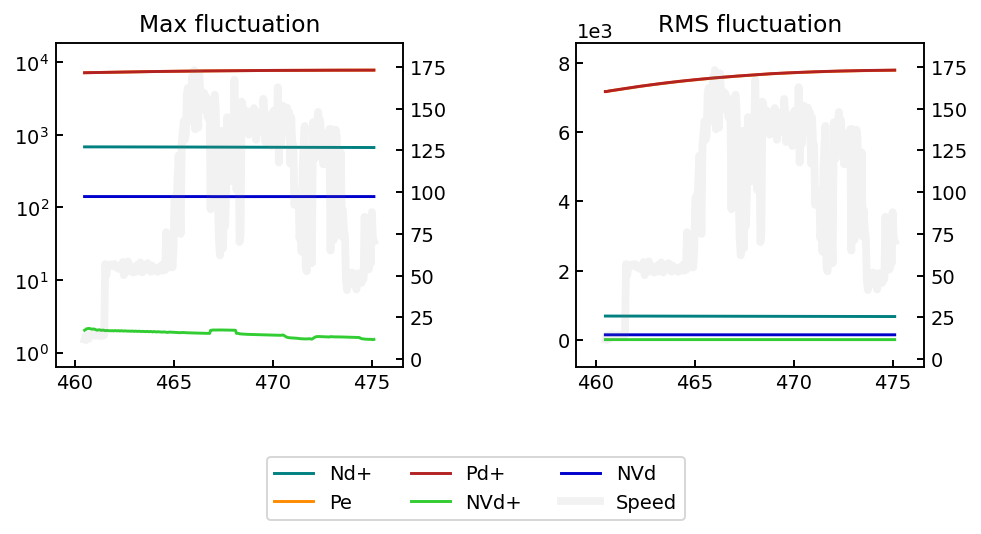

In [36]:
name = "base"
ds = cs[name].ds

t = ds["t"] * 1000
stime = np.diff(t, prepend = t[0]*0.99)
ms_per_24hrs = (stime) / (ds["wtime"]/(60*60*24))  # ms simulated per 24 hours

params = ["Nd+", "Pe", "Pd+", "NVd+", "NVd"]
# params = ["NVd+"]

fig, axes = plt.subplots(1, 2, figsize = (8, 3))

for i, param in enumerate(params):
    
    
    ddt = ds[f"ddt({param})"] + 1e-10
    ddt = ddt / ddt.attrs["conversion"]
    ddt = ddt.values
    
    data = ds[param] + 1e-10
    data = data / data.attrs["conversion"]
    data = data.values
    
    diff = ddt
    diff_max = np.mean(diff, axis = (1,2))
    # diff_max = np.max(diff, axis=(1,2))
    diff_rms = np.sqrt(np.mean(diff, axis=(1,2))**2)

    # t = ds["t"].values
    ax = axes[0]
    ax.set_title("Max fluctuation")
    ax.plot(t[1:], diff_max[1:],  label = param)
    ax.set_yscale("log")
    
    # t = ds["t"].values
    ax = axes[1]
    ax.set_title("RMS fluctuation")
    ax.plot(t[1:], diff_rms[1:])

speed_style = dict(c = "grey", alpha = 0.1, lw = 4)
    
for i, ax in enumerate(axes):
    ax2 = ax.twinx()
    if i == 0:
        label = "Speed"
    else:
        label = ""
    ax2.plot(t[1:], ms_per_24hrs[1:], **speed_style, label = label)
    
fig.subplots_adjust(wspace = 0.5)
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.1), ncols = 3)


In [7]:
ds["t"].values[-7]

np.float64(0.6812511943022755)

## Variable RMS fluctuations

### All timesteps

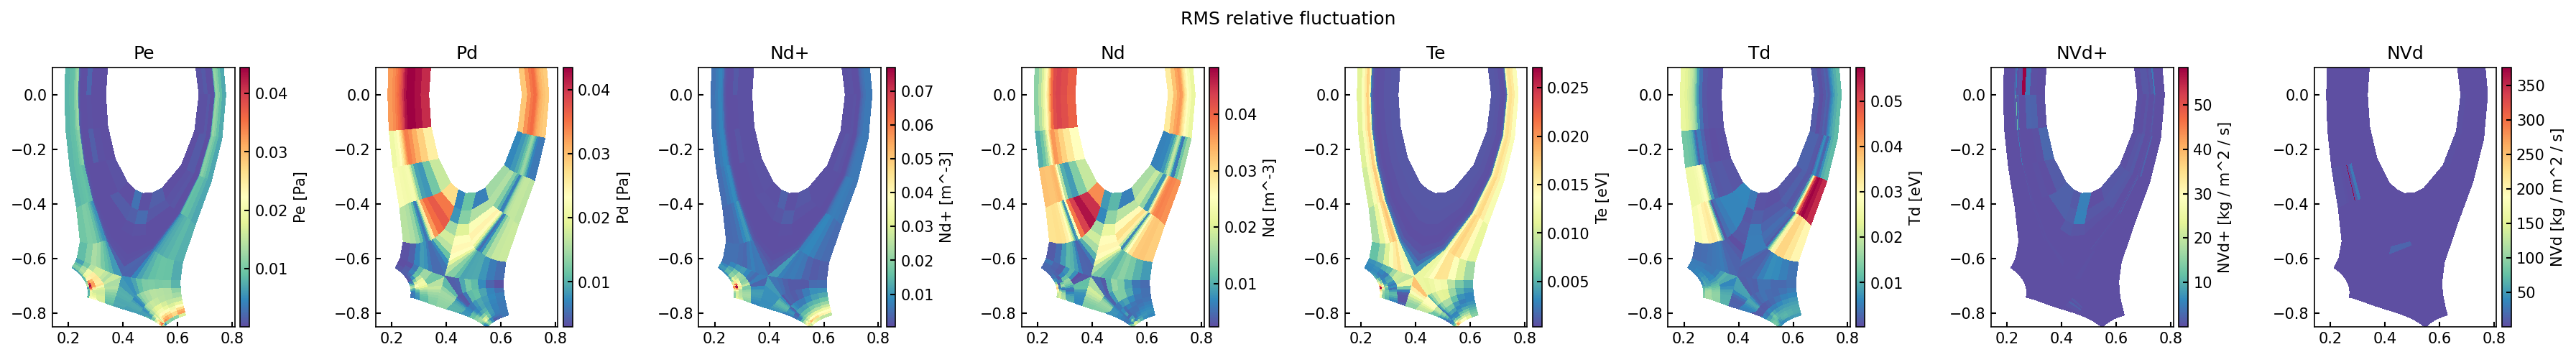

In [37]:
plot_fluctuations(cs["base"].ds, ["Pe", "Pd", "Nd+", "Nd", "Te", "Td", "NVd+", "NVd"], mode = "rel_variable_rms", ylims = (-0.85, 0.1))

# Animate ddt fluctuations

In [41]:
%matplotlib widget

## Electron pressure

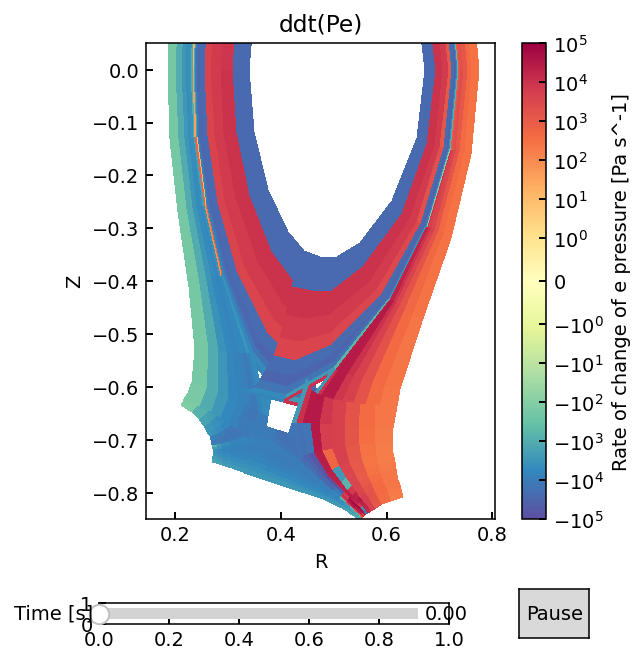

In [ ]:
plt.close("all")

fig, ax = plt.subplots(figsize = (5,5))
ax.set_ylim(-0.85, 0.05)
name = "base"

ds = cs[name].ds.isel(t=slice(5,None))

xbout.plotting.animate.animate_poloidal(
    ds["ddt(Pe)"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 10, 
    targets = False,
    logscale = True,
    separatrix = False,
    vmin = -1e6,
    vmax =  1e6
    )

## Ion momentum

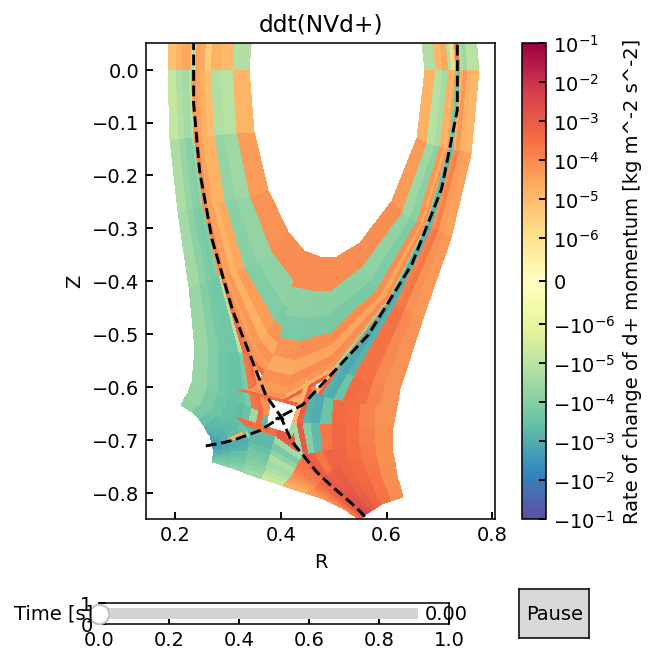

In [18]:
plt.close("all")

fig, ax = plt.subplots(figsize = (5,5))
ax.set_ylim(-0.85, 0.05)
name = "base"

ds = cs[name].ds.isel(t=slice(5,None))

xbout.plotting.animate.animate_poloidal(
    ds["ddt(NVd+)"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 10, 
    targets = False,
    logscale = True,
    separatrix = True,
    vmin = -0.1,
    vmax =  0.1
    )

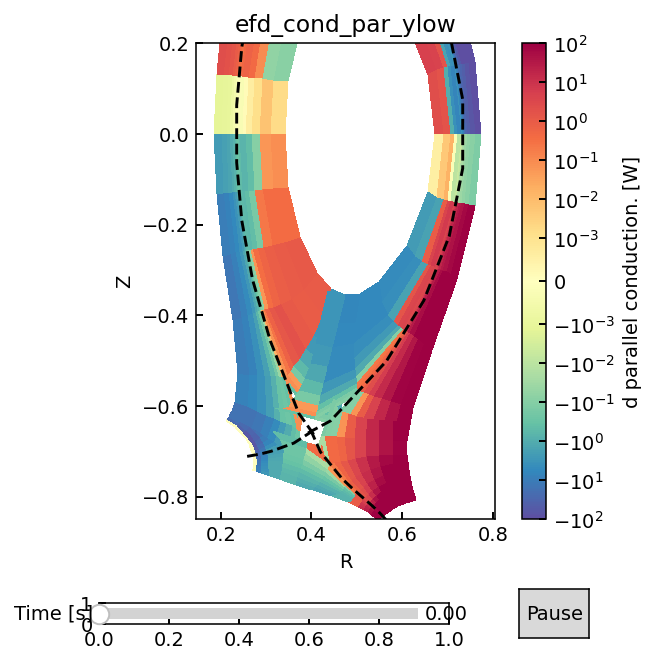

In [44]:
plt.close("all")

fig, ax = plt.subplots(figsize = (5,5))
ax.set_ylim(-0.85, 0.2)
name = "base"

ds = cs[name].ds.isel(t=slice(5,None))

xbout.plotting.animate.animate_poloidal(
    ds["efd_cond_par_ylow"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 10, 
    targets = False,
    logscale = True,
    separatrix = True,
    vmin = -1e2,
    vmax =  1e2
    )

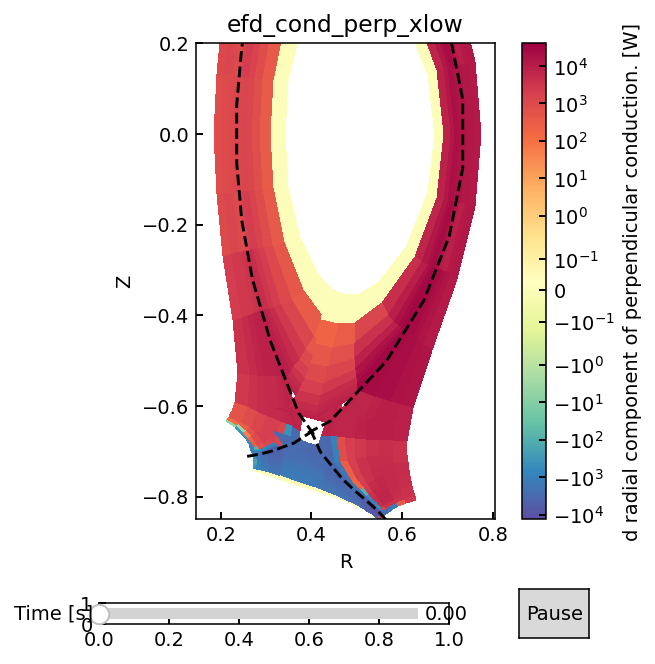

In [47]:
plt.close("all")

fig, ax = plt.subplots(figsize = (5,5))
ax.set_ylim(-0.85, 0.2)
name = "base"

ds = cs[name].ds.isel(t=slice(5,None))

xbout.plotting.animate.animate_poloidal(
    ds["efd_cond_perp_xlow"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 10, 
    targets = False,
    logscale = True,
    separatrix = True,
    vmin = None,
    vmax = None
    )

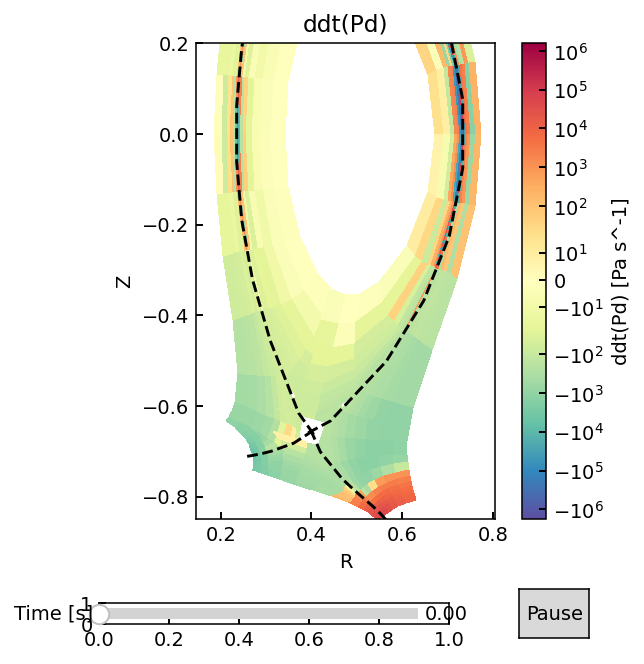

In [48]:
plt.close("all")

fig, ax = plt.subplots(figsize = (5,5))
ax.set_ylim(-0.85, 0.2)
name = "base"

ds = cs[name].ds.isel(t=slice(5,None))

xbout.plotting.animate.animate_poloidal(
    ds["ddt(Pd)"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 10, 
    targets = False,
    logscale = True,
    separatrix = True,
    vmin = None,
    vmax = None
    )

# Find fluctuations in core rings

In [19]:
%matplotlib inline

In [22]:
len(t)

301

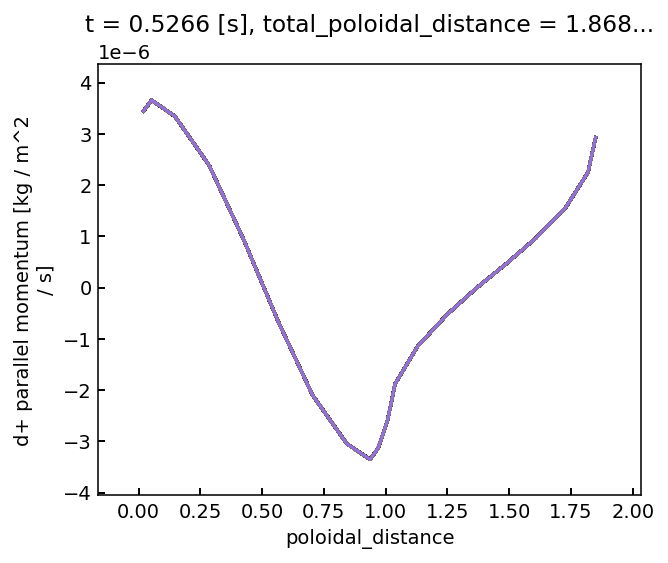

In [ ]:
fig, ax = plt.subplots()

ds = cs[name].ds
m = ds.metadata
ixseps = m["ixseps1"]

t = ds["t"].values
core = ds.hermesm.select_custom_core_ring(0)

for tind in range(1,len(t)):
    core["NVd+"].isel(t=tind).plot(ax = ax, x = "poloidal_distance", lw = 0.5)



## Animation

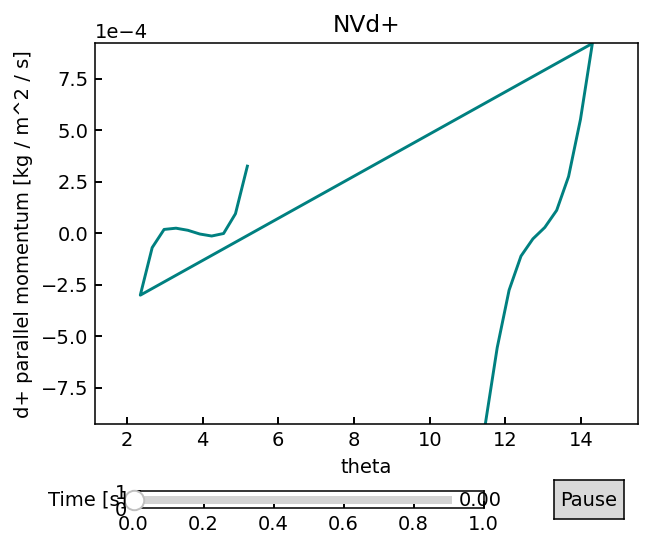

In [20]:
plt.close("all")

ds = cs[name].ds
m = ds.metadata

core = ds.hermesm.select_custom_core_ring(8).squeeze()
core = core.isel(t=slice(5,None))

fig, ax = plt.subplots()

xbout.plotting.animate.animate_line(
    core["NVd+"], 
    ax = ax,
    axis_coords = dict(poloidal_distance = core.coords["poloidal_distance"])
    )
    

ax.logscale = True

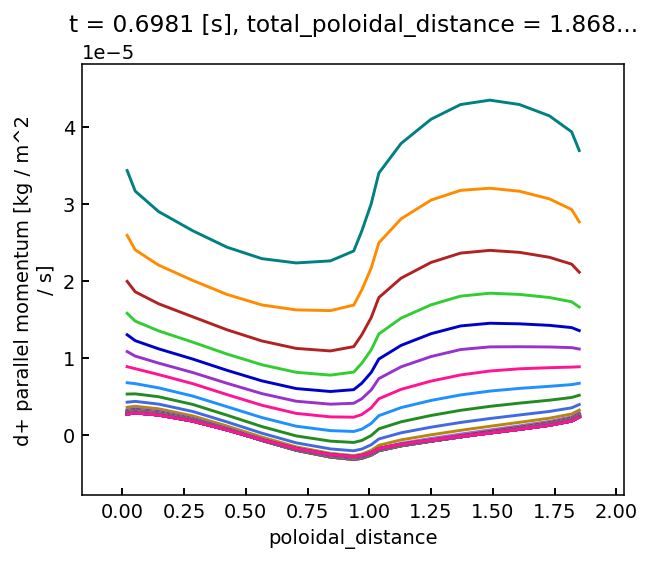

# Find fluctuations in SOL rings

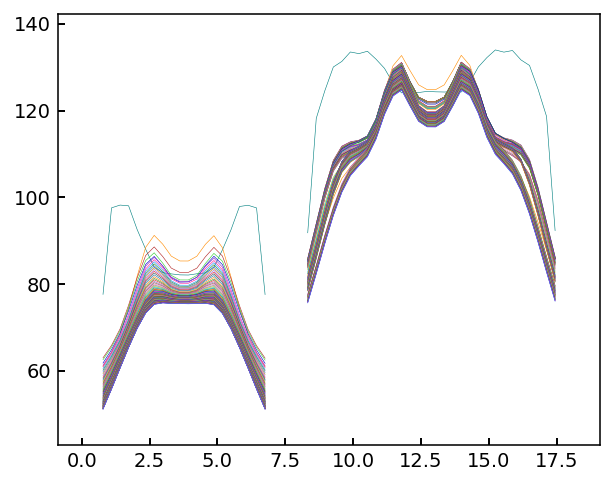

In [ ]:
fig, ax = plt.subplots()

ds = cs[name].ds
m = ds.metadata
ixseps = m["ixseps1"]

t = ds["t"].values

for tind in range(len(t)):
    data = ds["Pe"].hermesm.clean_guards()
    ring = data.isel(x = ixseps + 1).isel(t=tind)
    ax.plot(ring.coords["theta"], ring, lw = 0.5)


In [80]:
%matplotlib inline

# Rest

(-0.85, 0.05)

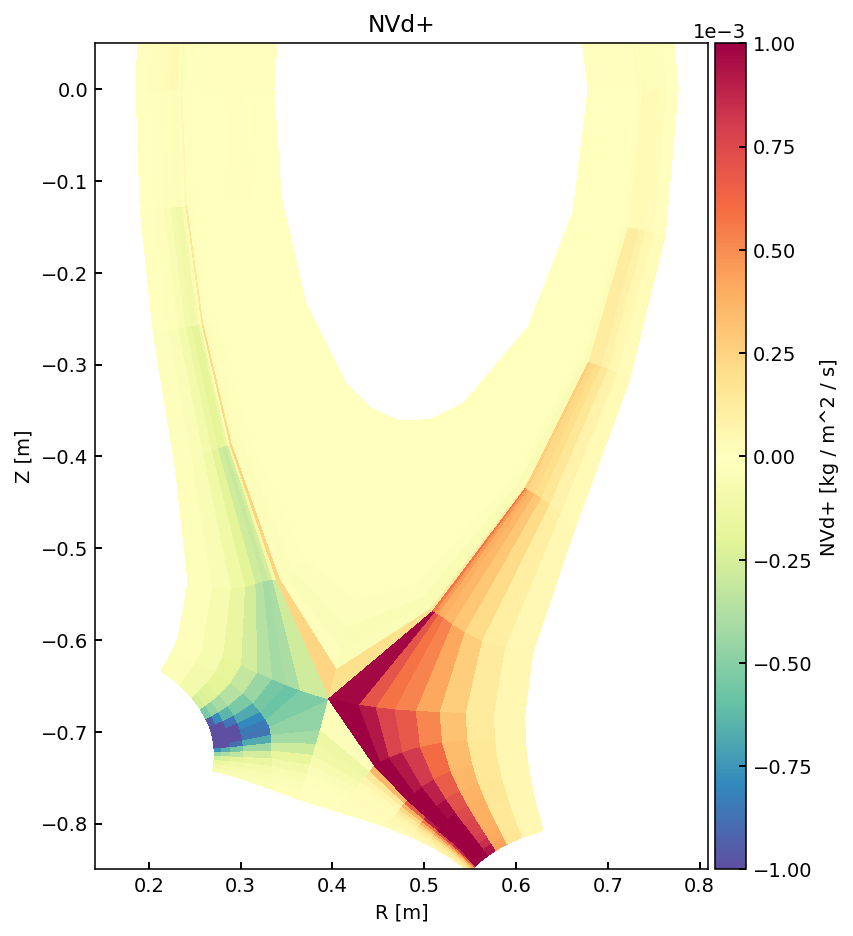

In [7]:
plt.close("all")

fig, ax = plt.subplots(figsize = (6,12))

name = "fixlax"

ds = cs[name].ds.isel(t=-1)

# data = ds["NVd+"].diff(dim = "t") / ds["NVd+"]
data = ds["NVd+"]


data.hermesm.clean_guards().bout.polygon( 
    ax = ax, 
    cmap = "Spectral_r", 
    targets = False,
    logscale = False,
    separatrix = False,
    vmin = -1e-3,
    vmax =  1e-3
    )
    
ax.set_ylim(-0.85, 0.05)


In [31]:
%matplotlib inline

Text(0.5, 1.0, 'Ion momentum in 1st core ring')

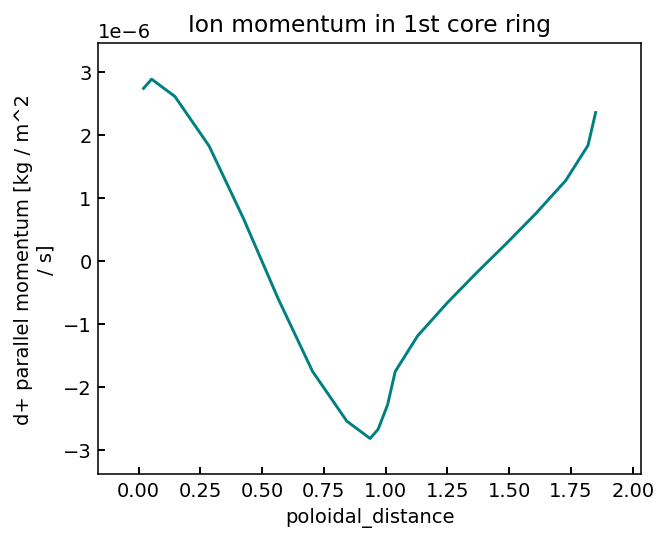

In [9]:
fig, ax = plt.subplots()

core = ds.hermesm.select_custom_core_ring(0)

# ax.plot(core["theta"], core["NVd+"].squeeze())
core["NVd+"].plot(ax = ax, x = "poloidal_distance")
ax.set_title("Ion momentum in 1st core ring")

In [5]:
cs.keys()

dict_keys(['base', 'fixlax'])

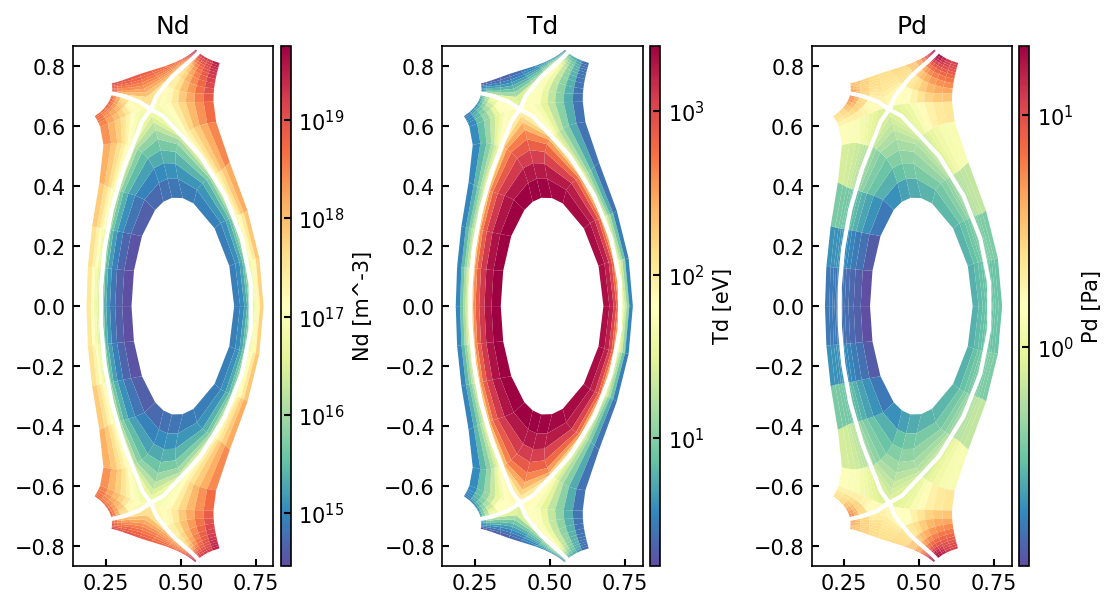

In [6]:
fig, axes = plt.subplots(1,3, figsize = (3.0*3,4.5), dpi = 150)
cmap = "Spectral_r"

name = "fixlax"

ds = cs[name].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)

for i, param in enumerate(["Nd", "Td", "Pd"]):
  
  data = ds[param]
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                        # colorbar_label="Test",
                                                        antialias = True,
                                                        logscale = True,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")